In [1]:
from typing import Dict

import torch

from deepfloyd_if.pipelines import dream
from deepfloyd_if.modules import T5Embedder, IFStageI, IFStageII, StableStageIII
from deepfloyd_if.finetune.textual_inversion import add_vtokens, object_variations

/home/jiaqiguo/miniconda3/envs/deepfloyd/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


FORCE_MEM_EFFICIENT_ATTN= 0 @UNET:QKVATTENTION


A matching Triton is not available, some optimizations will not be enabled.
Error caught was: No module named 'triton'


In [53]:
DEVICE = "cuda:0"
CKPT_PATH = "/data/jiaqi/if_ckpts/textual_inversion_step20000_lr_5e-2_wo_scale_variations/learned_embeds-step-20000.bin"

NUM_VTOKENS = 1

In [3]:
def load_vtoken_embeds(ckpt: Dict, t5: T5Embedder) -> None:
    token_embeds = t5.model.get_input_embeddings().weight.data
    for vid, vembed in ckpt.items():
        token_embeds[vid] = vembed.to(t5.model.device)

In [4]:
t5 = T5Embedder(device="cpu", torch_dtype=torch.float32, use_offload_folder=None)
vtoken_seq, vtoken_ids = add_vtokens(t5, num_tokens=NUM_VTOKENS, init_token=None)

/home/jiaqiguo/miniconda3/envs/deepfloyd/lib/python3.8/site-packages/huggingface_hub/file_download.py:1104: FutureWarning: The `force_filename` parameter is deprecated as a new caching system, which keeps the filenames as they are on the Hub, is now in place.
  warnings.warn(
Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:06<00:00,  3.01s/it]


VToken ids: [32100]


In [54]:
ckpt = torch.load(CKPT_PATH)
load_vtoken_embeds(ckpt, t5)

In [5]:
if_I = IFStageI('IF-I-XL-v1.0', device=DEVICE, model_kwargs={"precision": 32})
if_I.model.to(dtype=if_I.model.dtype)

UNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=704, out_features=2816, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=2816, out_features=2816, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(3, 704, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 704, eps=1e-05, affine=True)
          (1): GELU(approximate='none')
          (2): Conv2d(704, 704, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): GELU(approximate='none')
          (1): Linear(in_features=2816, out_features=1408, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 704, eps=1e-05, affine=True)
          (1): GELU(approximate='none')
          (2): Dropout(p

In [55]:
variation = "doll, white background"
test_prompt = "a photo of a {} {}".format(vtoken_seq, variation)
print(test_prompt)

a photo of a sks doll, white background


In [56]:
result = dream(
    t5=t5, if_I=if_I,
    prompt=[test_prompt],
    seed=42,
    if_I_kwargs={
        "guidance_scale": 7.0,
        "sample_timestep_respacing": "smart100",
    },
)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.05it/s]


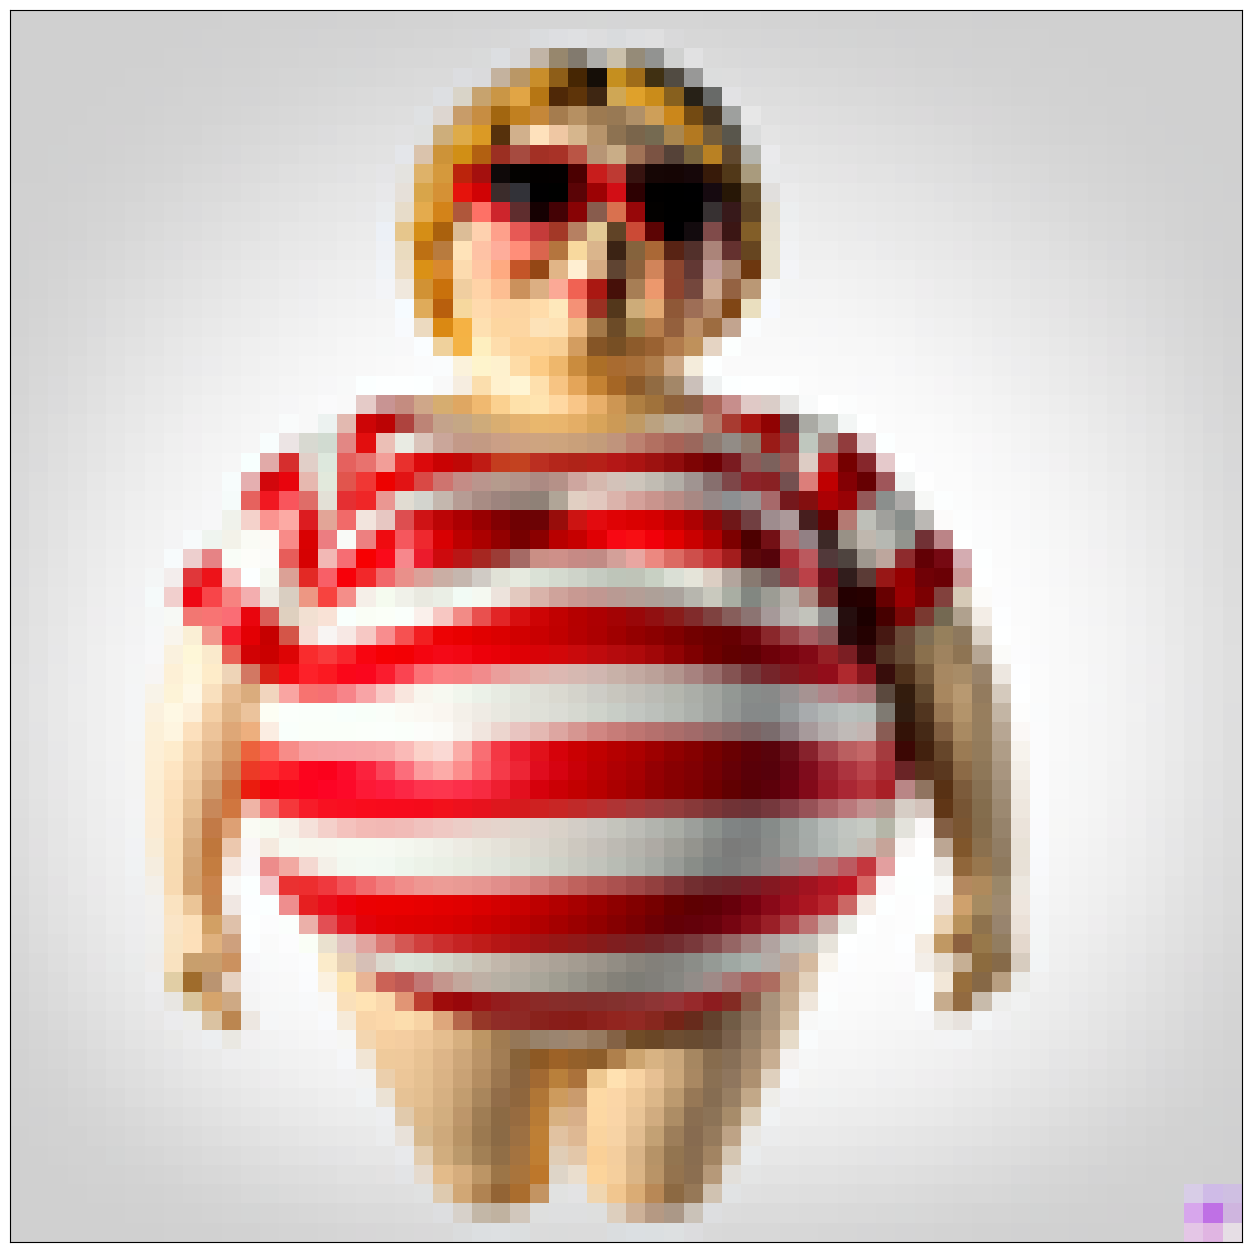

In [57]:
if_I.show(result['I'], size=16)

a photo of a my doll, white background


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:25<00:00,  3.99it/s]


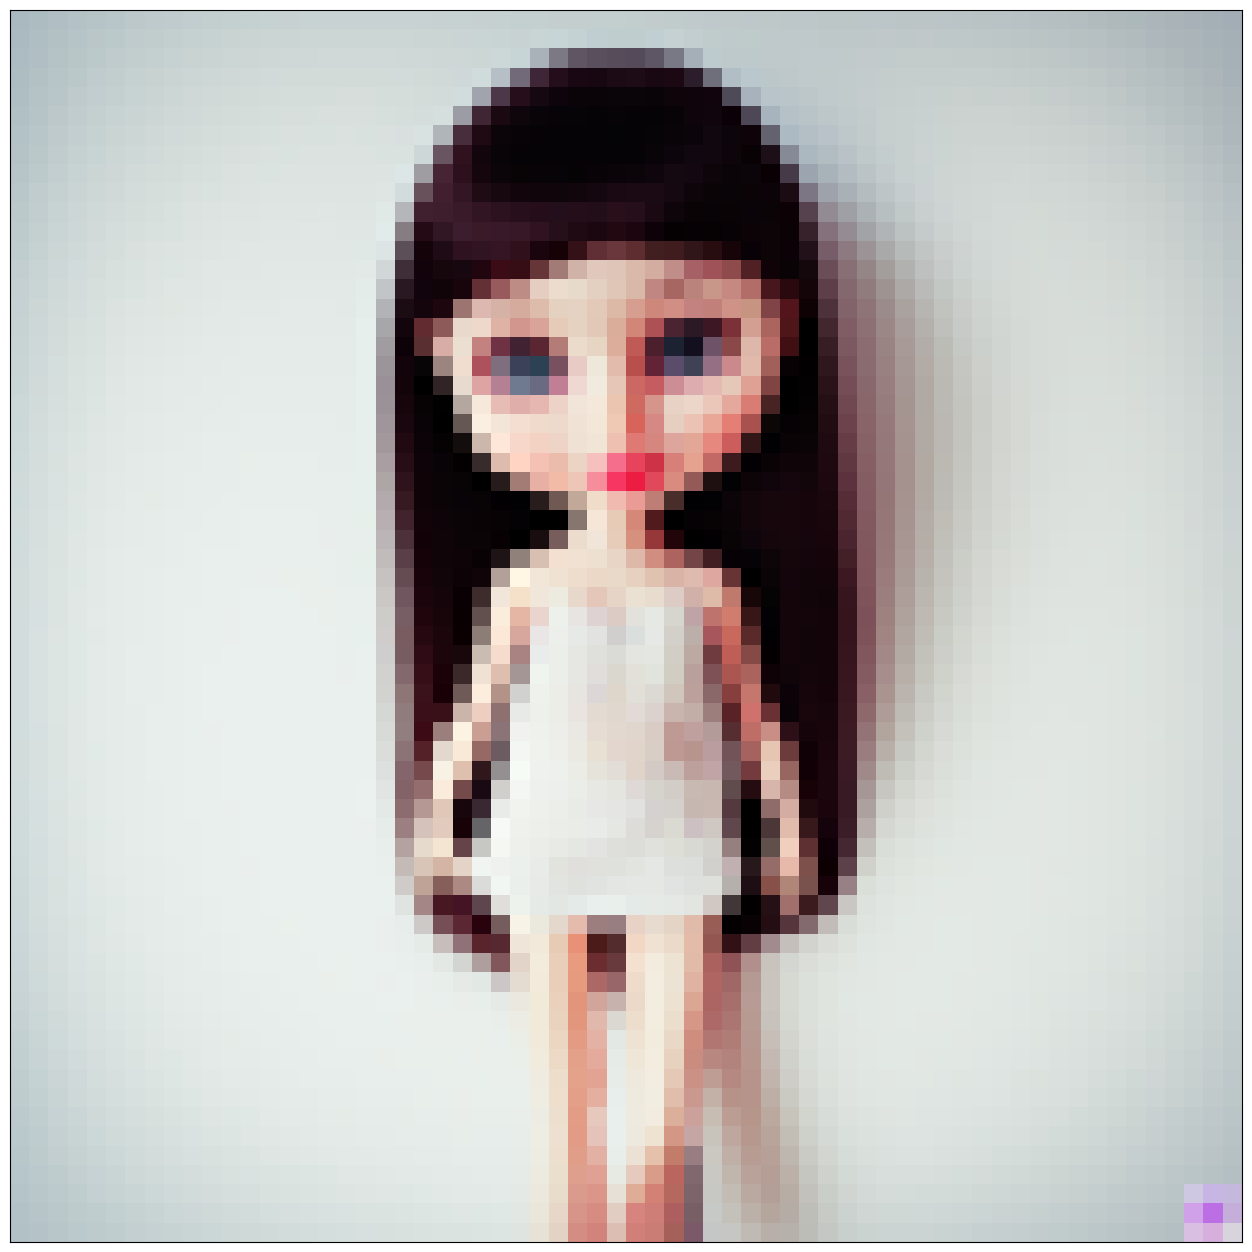

In [9]:
init_prompt = "a photo of a {} {}".format("my", variation)
print(init_prompt)

init_result = dream(
    t5=t5, if_I=if_I,
    prompt=[init_prompt],
    seed=42,
    if_I_kwargs={
        "guidance_scale": 7.0,
        "sample_timestep_respacing": "smart100",
    },
)

if_I.show(init_result['I'], size=16)

In [10]:
# check embeddings
init_token_id = t5.tokenizer.encode("my", add_special_tokens=False)[0]
init_token_embed = t5.model.get_input_embeddings().weight.data[init_token_id]
vtoken_embed = t5.model.get_input_embeddings().weight.data[vtoken_ids[0]]

In [11]:
init_token_embed

tensor([ 2.0000, -0.7070, -1.5938,  ..., -2.9062, -2.8281,  2.3594])

In [12]:
vtoken_embed

tensor([ 5.8521,  6.1492,  8.0293,  ...,  1.9756, -2.1111,  5.1046])

In [13]:
ckpt

{32100: tensor([ 5.8521,  6.1492,  8.0293,  ...,  1.9756, -2.1111,  5.1046])}

In [14]:
if_II = IFStageII('IF-II-L-v1.0', device=DEVICE, model_kwargs={"precision": 32})
if_II.model.to(dtype=if_II.model.dtype)

SuperResUNetModel(
  (time_embed): Sequential(
    (0): Linear(in_features=160, out_features=1280, bias=True)
    (1): GELU(approximate='none')
    (2): Linear(in_features=1280, out_features=1280, bias=True)
  )
  (input_blocks): ModuleList(
    (0): TimestepEmbedSequential(
      (0): Conv2d(6, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (1): TimestepEmbedSequential(
      (0): ResBlock(
        (in_layers): Sequential(
          (0): GroupNorm32(32, 160, eps=1e-05, affine=True)
          (1): GELU(approximate='none')
          (2): Conv2d(160, 160, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (h_upd): Identity()
        (x_upd): Identity()
        (emb_layers): Sequential(
          (0): Identity()
          (1): Linear(in_features=1280, out_features=320, bias=True)
        )
        (out_layers): Sequential(
          (0): GroupNorm32(32, 160, eps=1e-05, affine=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.0, i

## Test

a photo of a sks doll in the gardens of Versailles


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:12<00:00,  4.15it/s]


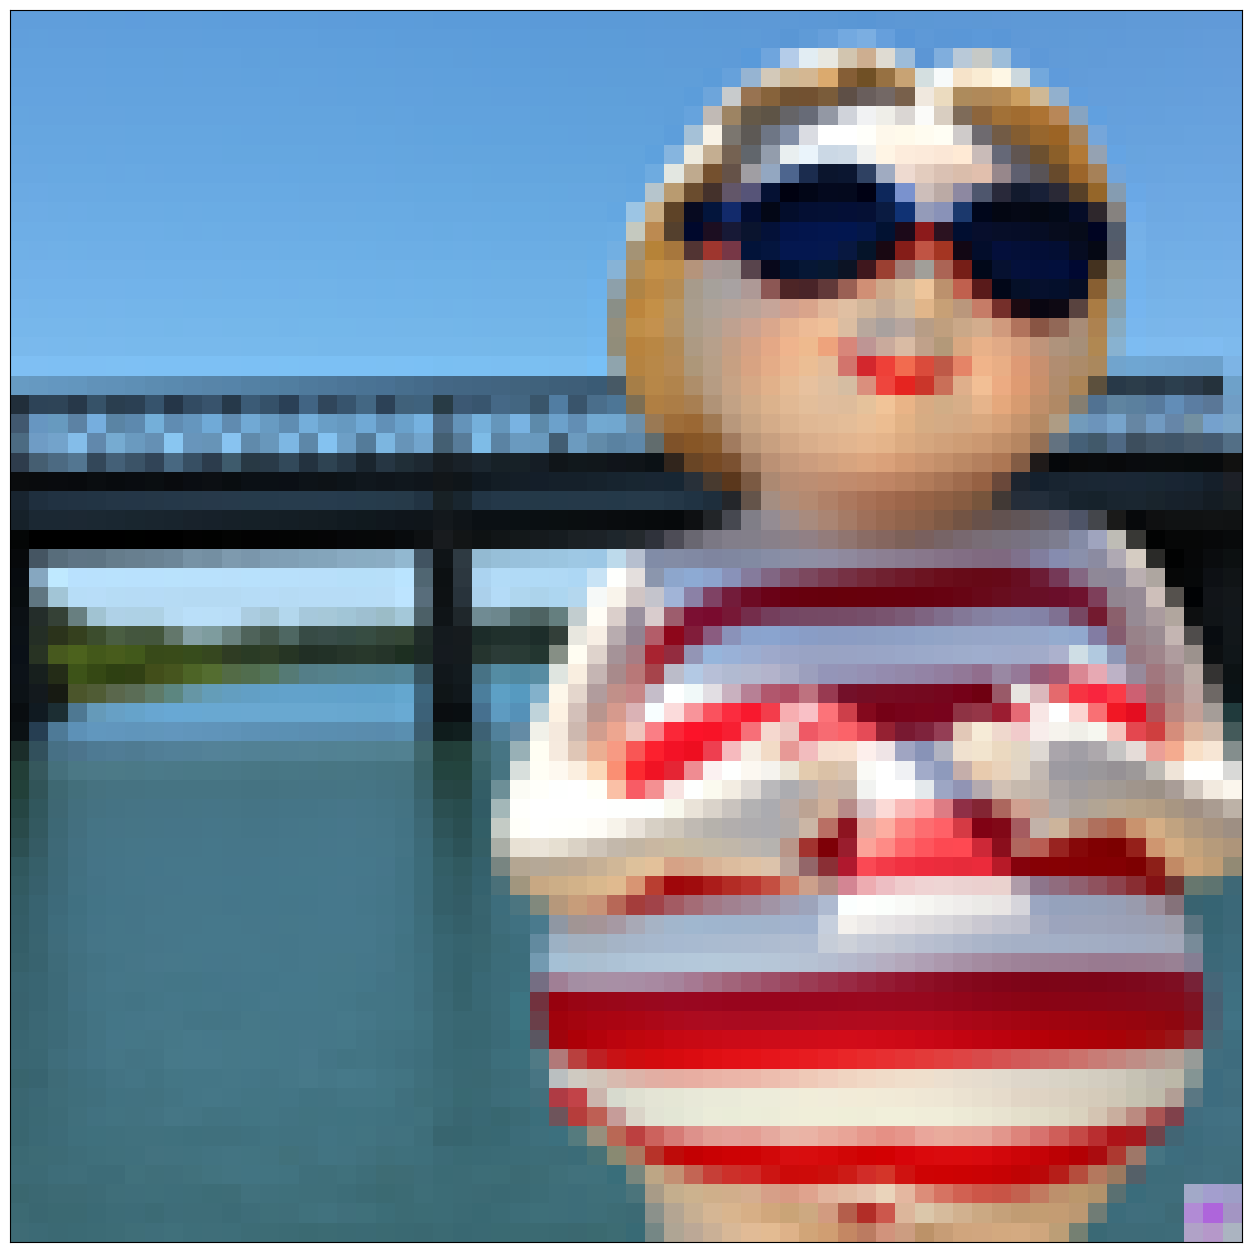

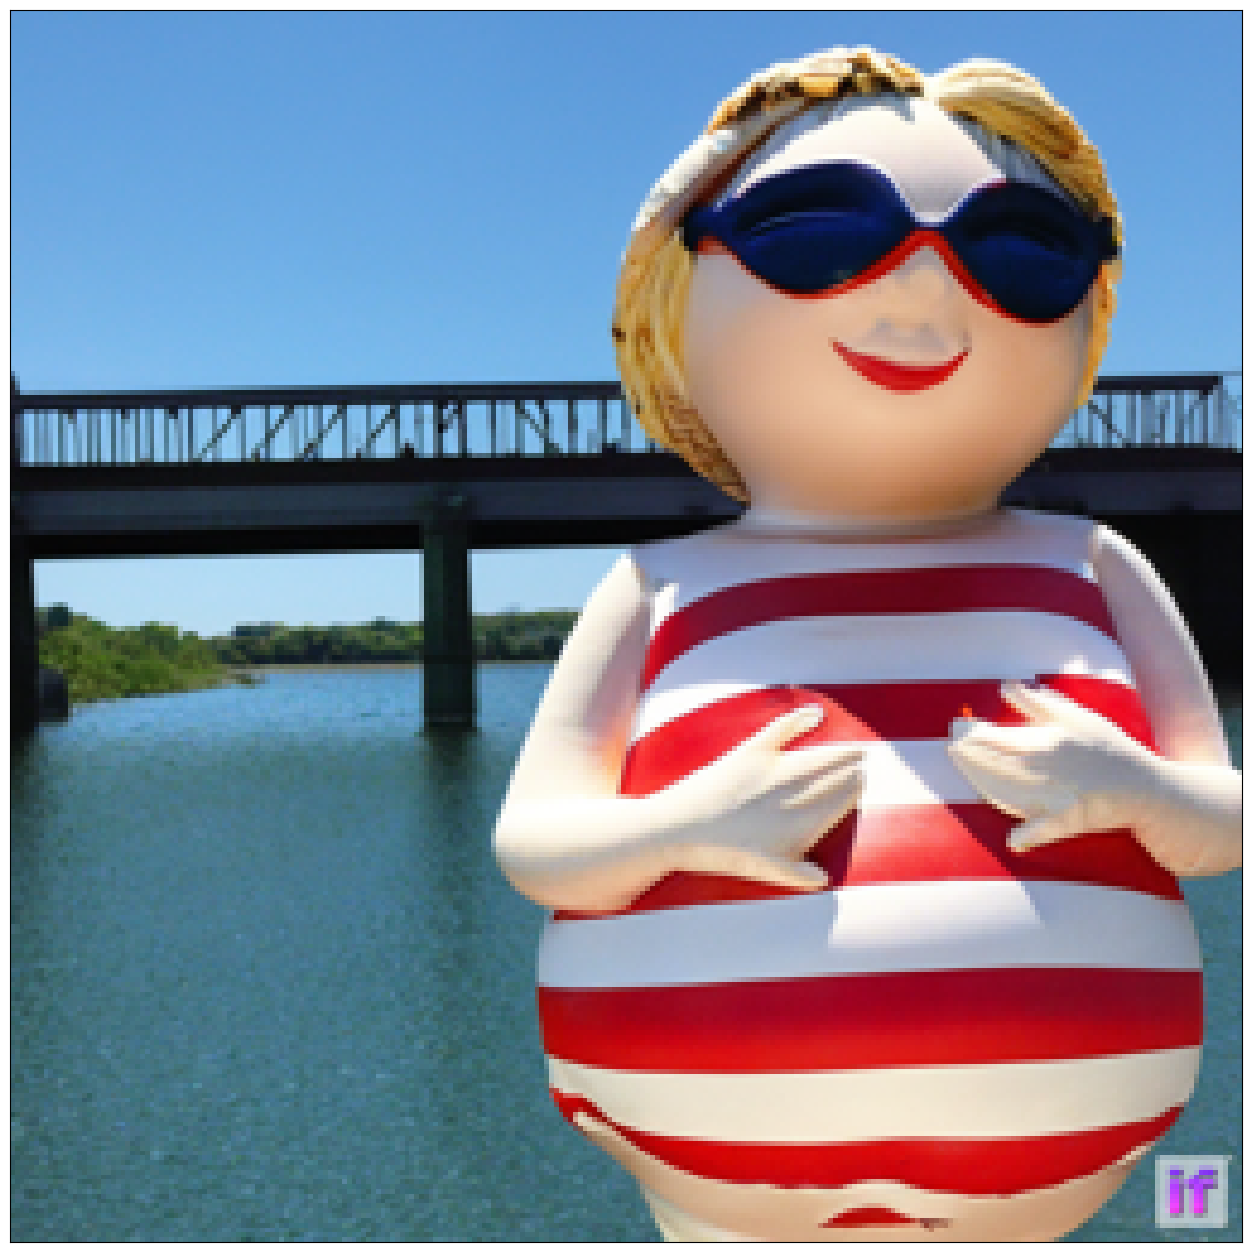

In [58]:
scenarios = ["doll, black background", "doll in the gardens of Versailles"]
fun_prompt = "a photo of a {} {}".format(vtoken_seq, scenarios[1])
print(fun_prompt)

fun_prompt = "a photo of a sks doll with a bridge in the background"

fun_result = dream(
    t5=t5, if_I=if_I, if_II=if_II,
    prompt=[fun_prompt],
    seed=42,
    if_I_kwargs={
        "guidance_scale": 7.0,
        "sample_timestep_respacing": "smart100",
    },
    if_II_kwargs={
        "guidance_scale": 4.0,
        "sample_timestep_respacing": "smart50"
    },
)

if_I.show(fun_result['I'] , size=16)
if_II.show(fun_result['II'] , size=16)

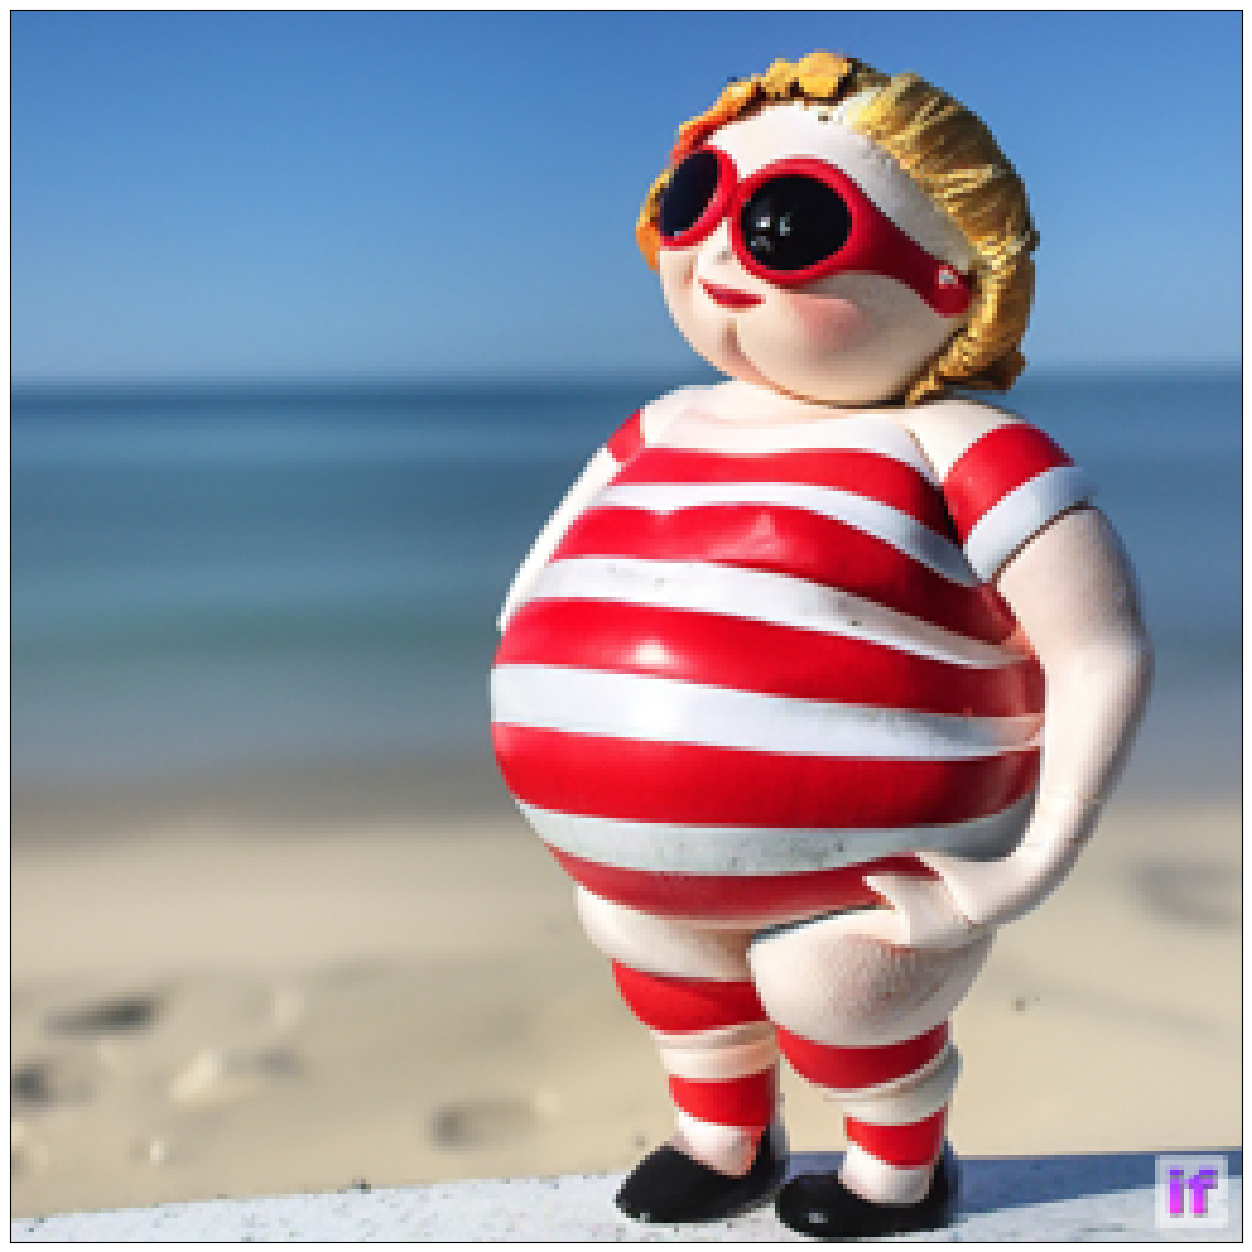

In [34]:
if_II.show(fun_result['II'], size=16)